Create datasets and data frames, plan out strategy

Aim: single channel eye blink detection for channel not proximal to eyes (Cz)

Steps:
1. Break down into test, train and validation sets (3, 13, 3)
2. Epoch data DONE
3. Label test and validation sets and subset of training sets (3, 3, 3)
4. Create waveform statistical features to be used for data analysis from all the training and validation datasets
5. Check if PCA or others reveal any redundant features and reduce dimensions
6. Run K means in unsupervised method and assign labels based on labeled training sets


3 methods:
1. kmeans: waveform statistical features
2. kmeans: pca
3. kmeans: dynamic time warping with raw time series -> Raw time series takes too long with my computing power


In [ ]:
#import all libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from MLModelHelper import create_waveform_features

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
import joblib
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from dtaidistance import dtw
from tslearn.clustering import TimeSeriesKMeans


Load training and validation datasets
(converted back to numpy array from saved dataframe due to signalprocessing ease on nd arrays)

In [ ]:
sampling_freq = 256 #Sampling frequencies

#Load dataframes, convert back to numpy for simpler feature generation
Cz_train_unlabeled = pd.read_csv (r'Cz_train_unlabeled_df.csv', header=0).to_numpy() #unlabeled training set: unsupervised
Cz_train_labeled = pd.read_csv (r'Cz_train_labeled_df.csv', header=0).to_numpy() #labeled training set: supervised
Cz_val = pd.read_csv (r'Cz_val_df.csv', header=0).to_numpy() #labeled validation set

Cz_train_labeled_Labels = pd.read_csv (r'Cz_train_labeled_Labels.csv', header=0).to_numpy().ravel() #labels for supervised training
Cz_val_Labels = pd.read_csv (r'Cz_val_Labels.csv', header=0).to_numpy().ravel() #labels for validation
print(Cz_train_labeled_Labels.shape)

Cz_train = np.append(Cz_train_labeled,Cz_train_unlabeled, axis=0) #combine all training features
print(Cz_train.shape)


(1800,)
(7800, 128)


Extracting features from the time series epochs (0.5 secs each):
'mean', 'median', 'std', 'variance', 'skew', 'kurtosis', 'Range', 'maxPeakWidth', 'maxTroughWidth', 'lfPower', 'hfPower', 'HjorthMobility', 'HjorthComplexity'

These features can help define wave characteristics


In [ ]:
#ml helper function to create the features
[feature_names, Cz_train_unlabeled_features] = createFeatures(Cz_train_unlabeled, sampling_freq)
[feature_names, Cz_train_labeled_features] = createFeatures(Cz_train_labeled, sampling_freq)

#combine entire training set (include both unlabeled and labeled sets)
Cz_train_features = np.append(Cz_train_labeled_features,Cz_train_unlabeled_features, axis=0)
print(Cz_train_features.shape)
print(feature_names)

(7800, 13)
['mean', 'median', 'std', 'variance', 'skew', 'kurtosis', 'Range', 'maxPeakWidth', 'maxTroughWidth', 'lfPower', 'hfPower', 'HjorthMobility', 'HjorthComplexity']


Run PCA on these features to transform and reduce dimensionality into principal components
1. Scale all features
2. Run PCA
3. Visualize and choose number of PCs based on explained variance

In [ ]:


feature_scaler = StandardScaler().fit(Cz_train_features)
scaled_Cz_train = feature_scaler.transform(Cz_train_features)

pca_trained = PCA(n_components = 2)
Cz_train_PC = pca_trained.fit_transform(scaled_Cz_train)

explained_variance = pca_trained.explained_variance_ratio_ 
print(explained_variance) #explains 50% variance, can stick to two

[0.34241645 0.18950257]


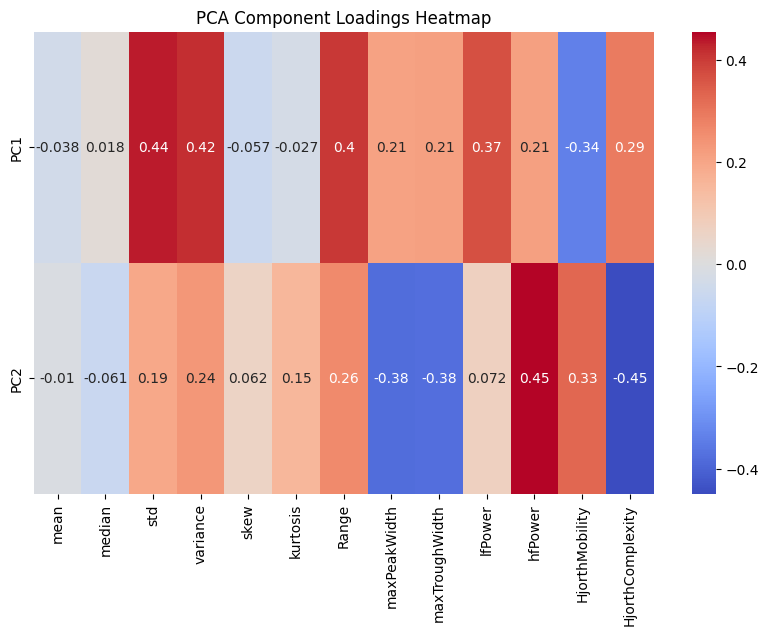

In [60]:
loadings = pd.DataFrame(pca_trained.components_, columns=feature_names, index=[f'PC{i+1}' for i in range(pca_trained.n_components_)])

plt.figure(figsize=(10, 6))
sns.heatmap(loadings, cmap='coolwarm', annot=True)
plt.title('PCA Component Loadings Heatmap')
plt.show()

In [ ]:
#separate supervised and unsupervised
Cz_train_labeled_PC = Cz_train_PC[0:1800,:]
Cz_train_unlabeled_PC = Cz_train_PC[1800:,:]


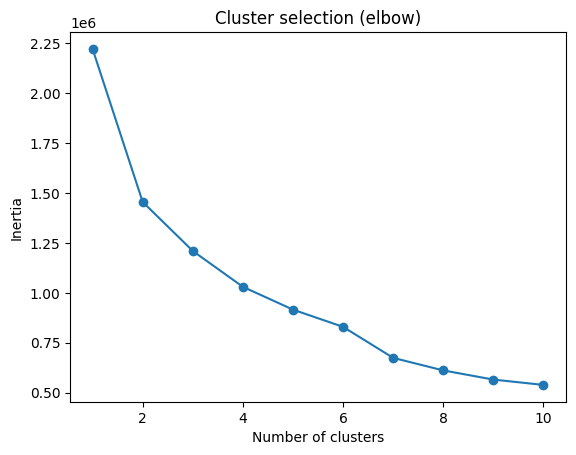

In [61]:
#Test feature kmeans and choose clusters using elbow method
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=8)
    kmeans.fit(Cz_train_features)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Cluster selection (elbow)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Adjusted Rand Index: 0.129
Normalized Mutual Information: 0.078
Accuracy: 0.6916666666666667
(1800,)
Cluster-label-mapped accuracy: 0.793


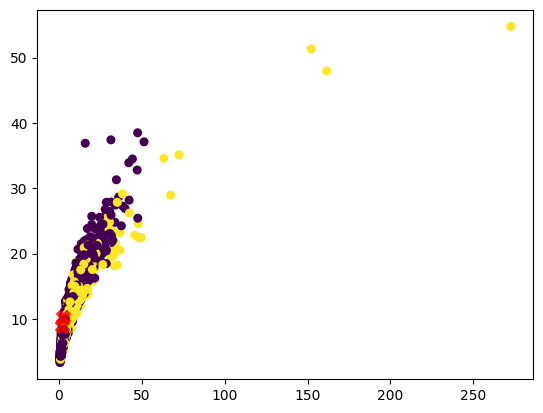

(2, 2)


In [ ]:
kmeans_features = KMeans(n_clusters=2, random_state=8)
kmeans_features.fit(Cz_train_features)

Cz_train_labeled_predictions = kmeans_features.predict(Cz_train_labeled_features)

#test how well the kmeans predictions are
ari = adjusted_rand_score(Cz_train_labeled_Labels, Cz_train_labeled_predictions)
nmi = normalized_mutual_info_score(Cz_train_labeled_Labels, Cz_train_labeled_predictions)

print(f'Adjusted Rand Index: {ari:.3f}')
print(f'Normalized Mutual Information: {nmi:.3f}')

conf_mat = confusion_matrix(Cz_train_labeled_Labels, Cz_train_labeled_predictions)

print("Accuracy:",metrics.accuracy_score(Cz_train_labeled_Labels, Cz_train_labeled_predictions))

mapping = {}
for cluster_idx in range(conf_mat.shape[1]):
    true_label = np.argmax(conf_mat[:, cluster_idx])
    mapping[cluster_idx] = true_label


mapped_labels = np.vectorize(mapping.get)(Cz_train_labeled_predictions).flatten()


# 6. Evaluate mapped clustering as classification predictions
acc = accuracy_score(Cz_train_labeled_Labels, mapped_labels)
print(f'Cluster-label-mapped accuracy: {acc:.3f}')

centroids = kmeans_features.cluster_centers_
plt.scatter(Cz_train_features[:, 3],Cz_train_features[:, 6],  c=kmeans_features.labels_, s=30, cmap='viridis')
plt.scatter(centroids[:, 2], centroids[:, 6], c='red', s=100, alpha=0.75, marker='X')

plt.show()


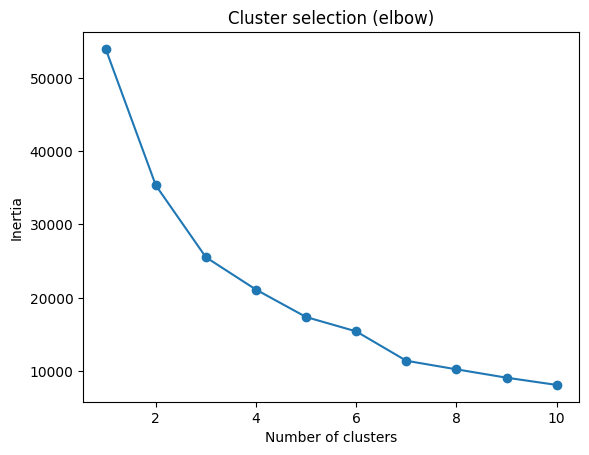

In [46]:
#Test feature kmeans using elbow method
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=8)
    kmeans.fit(Cz_train_PC)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Cluster selection (elbow)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Adjusted Rand Index: 0.331
Normalized Mutual Information: 0.204
Accuracy: 0.805
Cluster-label-mapped accuracy: 0.805


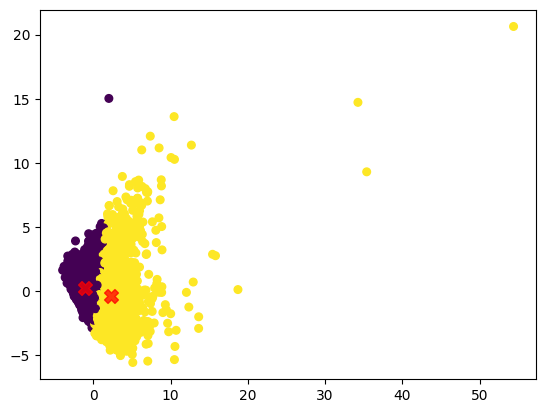

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=8)
kmeans.fit(Cz_train_PC)

Cz_train_labeled_predictions = kmeans.predict(Cz_train_labeled_PC)

#test how well the kmeans predictions are
ari_supervised = adjusted_rand_score(Cz_train_labeled_Labels, Cz_train_labeled_predictions)
nmi_supervised = normalized_mutual_info_score(Cz_train_labeled_Labels, Cz_train_labeled_predictions)

print(f'Adjusted Rand Index: {ari_supervised:.3f}')
print(f'Normalized Mutual Information: {nmi_supervised:.3f}')

conf_mat_supervised = confusion_matrix(Cz_train_labeled_Labels, Cz_train_labeled_predictions)
acc_supervised = accuracy_score(Cz_train_labeled_Labels, Cz_train_labeled_predictions)

print(f'Accuracy: {acc_supervised:.3f}')

mapping = {}
for cluster_idx in range(conf_mat_supervised.shape[1]):
    true_label = np.argmax(conf_mat_supervised[:, cluster_idx])
    mapping[cluster_idx] = true_label


mapped_labels = np.vectorize(mapping.get)(Cz_train_labeled_predictions).flatten()

# 6. Evaluate mapped clustering as classification predictions
acc_supervised_mapped = accuracy_score(Cz_train_labeled_Labels, mapped_labels)
print(f'Cluster-label-mapped accuracy: {acc_supervised_mapped:.3f}')

centroids = kmeans.cluster_centers_
plt.scatter(Cz_train_PC[:, 0],Cz_train_PC[:, 1],  c=kmeans.labels_, s=30, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, alpha=0.75, marker='X')

plt.show()


In [ ]:
Cz_train_unlabeled_predictions = kmeans.predict(Cz_train_unlabeled_PC)
mapped_labels = np.vectorize(mapping.get)(Cz_train_unlabeled_predictions).reshape(Cz_train_unlabeled_predictions.shape[0],1).flatten()
print(mapped_labels.shape)
print(Cz_train_unlabeled.shape)

repeated_mapped_labels = np.tile(mapped_labels, (1,128))
print(repeated_mapped_labels.shape)

Cz_train_unlabeled_joined = Cz_train_unlabeled.reshape(-1)
mapped_labels_joined = repeated_mapped_labels.reshape(-1)
print(Cz_train_unlabeled_joined.shape)
print(mapped_labels_joined.shape)


(6000,)
(6000, 128)
(1, 768000)
(768000,)
(768000,)


<Axes: xlabel='time', ylabel='value'>

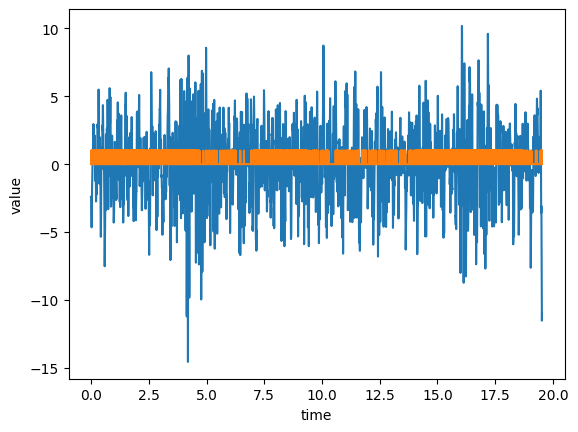

In [ ]:
timePts = 5000

timeSec = np.arange(timePts)*(1/sampling_freq)
Cz_train_unlabeled_joined_df =  pd.DataFrame({'time': timeSec, 'value': Cz_train_unlabeled_joined[:timePts], 'mapped_label': mapped_labels_joined[:timePts]})

sns.lineplot(data=Cz_train_unlabeled_joined_df,x= 'time', y='value')
sns.lineplot(data=Cz_train_unlabeled_joined_df,x= 'time', y='mapped_label')



In [50]:
# # 128 features (each data point) Hence takes too long
# tskmeans = TimeSeriesKMeans(n_clusters=2, metric="dtw", random_state=8)
# # Fit the model
# tskmeans.fit(Cz_train)

Better model seems to be with PCA,
Check validation accuracy:

In [ ]:
[feature_names, Cz_val_features] = createFeatures(Cz_val, sampling_freq)
Cz_val_scaled = feature_scaler.transform(Cz_val_features)
Cz_val_PC = pca_trained.transform(Cz_val_scaled)

Cz_val_predictions = kmeans.predict(Cz_val_PC)
val_mapped_labels = np.vectorize(mapping.get)(Cz_val_predictions).reshape(Cz_val_predictions.shape[0],1).flatten()

print("Accuracy:", accuracy_score(Cz_val_Labels, val_mapped_labels))
print("F1 score:", f1_score(Cz_val_Labels, val_mapped_labels, average=None))
print("Precision", precision_score(Cz_val_Labels, val_mapped_labels, average=None))
print("Recall:", recall_score(Cz_val_Labels, val_mapped_labels, average=None))


Accuracy: 0.843
Precision: 0.637
Recall: 0.795
F1 score: 0.707


[[1177  250]
 [ 101  272]]


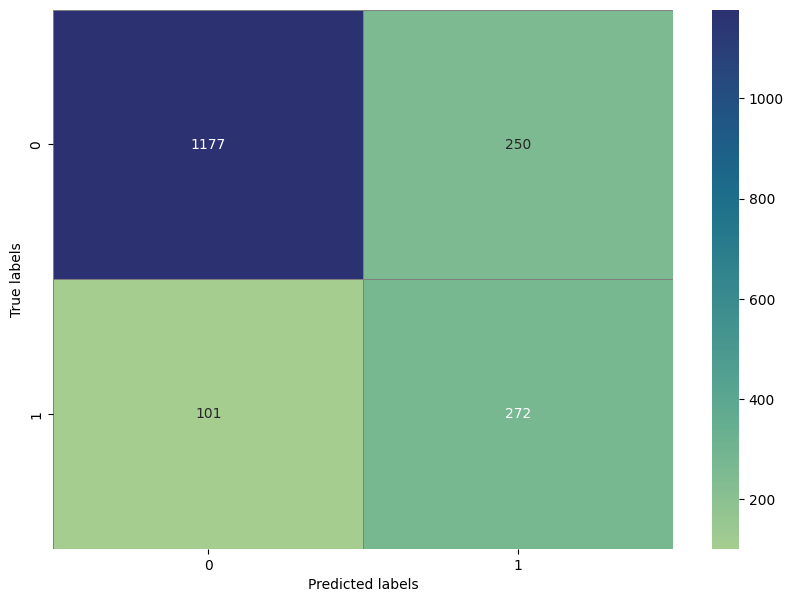

In [52]:
print(conf_mat_supervised)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_supervised, annot=True, fmt='d', cmap='crest', linewidths=0.5, linecolor='grey')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()